# **AI-Driven Smart Waste Management with Image Classification and Simulation**

# Setup

In [19]:
import os, json, cv2, shutil, random
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TF logs (0=all, 1=info, 2=warning, 3=error)

# Dataset path

In [2]:
DATASET_DIR = Path("/kaggle/input/smart-waste-classification-datasets")

# root directiry
print("Root:", os.listdir(DATASET_DIR))

# taco_raw 
print("taco_raw:", os.listdir(DATASET_DIR/"taco_raw"))

# taco_raw/taco_raw
print("taco_raw/taco_raw:", os.listdir(DATASET_DIR/"taco_raw"/"taco_raw")[:5])

# trashnet_raw
print("trashnet_raw:", os.listdir(DATASET_DIR/"trashnet_raw"))

# trashnet_raw/trashnet_raw
print("trashnet_raw/trashnet_raw:", os.listdir(DATASET_DIR/"trashnet_raw"/"trashnet_raw")[:5])

Root: ['taco_raw', 'trashnet_raw']
taco_raw: ['taco_raw']
taco_raw/taco_raw: ['batch_4', 'batch_1', 'batch_5', 'batch_14', 'all_image_urls.csv']
trashnet_raw: ['trashnet_raw']
trashnet_raw/trashnet_raw: ['metal', 'glass', 'paper', 'trash', 'cardboard']


# TACO Batches

In [3]:
DATASET_DIR = Path("/kaggle/input/smart-waste-classification-datasets")
TACO_RAW = DATASET_DIR/"taco_raw"/"taco_raw"
IMG_DIR = Path("/kaggle/working/datasets/taco_images")
IMG_DIR.mkdir(parents=True, exist_ok=True)

exts = ["*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"]

img_files = []

for batch in sorted(TACO_RAW.glob("batch_*")):
    for ext in exts:
        found = list(batch.glob(ext))
        if found:
            print(f"{batch.name} -> {len(found)} files ({ext})")
        img_files.extend(found)

print("Total found:", len(img_files))

batch_1 -> 48 files (*.jpg)
batch_1 -> 53 files (*.JPG)
batch_10 -> 100 files (*.jpg)
batch_11 -> 100 files (*.jpg)
batch_12 -> 100 files (*.jpg)
batch_13 -> 100 files (*.jpg)
batch_14 -> 100 files (*.jpg)
batch_15 -> 85 files (*.jpg)
batch_2 -> 92 files (*.JPG)
batch_3 -> 97 files (*.JPG)
batch_4 -> 89 files (*.JPG)
batch_5 -> 112 files (*.JPG)
batch_6 -> 97 files (*.JPG)
batch_7 -> 127 files (*.JPG)
batch_8 -> 100 files (*.jpg)
batch_9 -> 100 files (*.jpg)
Total found: 1500


# Path for TrashNet

In [4]:
TRASHNET_RAW = DATASET_DIR/"trashnet_raw"/"trashnet_raw"

for cls in os.listdir(TRASHNET_RAW):
    print("Class:", cls, "->", len(os.listdir(TRASHNET_RAW/cls)))

Class: metal -> 410
Class: glass -> 501
Class: paper -> 594
Class: trash -> 137
Class: cardboard -> 403
Class: plastic -> 482


# Label Mapping

In [5]:
LABEL_MAP = {
    "trashnet": {
        "glass": "recyclable",
        "plastic": "recyclable",
        "metal": "recyclable",
        "paper": "recyclable",
        "cardboard": "recyclable",
        "trash": "organic"
    },
    "taco": {
        "plastic bag": "recyclable",
        "can": "recyclable",
        "glass bottle": "recyclable",
        "paper": "recyclable",
        "food": "organic",
        "vegetation": "organic",
        "battery": "hazardous",
        "medical": "hazardous"
    }
}

# Preprocess TACO Data

In [6]:
import json
DATASET_DIR = Path("/kaggle/input/smart-waste-classification-datasets/taco_raw/taco_raw")
IMG_DIR = Path("/kaggle/working/datasets/taco_images")  # merged folder
OUT_BASE = Path("/kaggle/working/datasets")
OUT_TACO = OUT_BASE / "taco_classification"
ANN_FILE = DATASET_DIR / "annotations.json"

# Label mapping
LABEL_MAP = {
    "taco": {
        "plastic bag": "recyclable",
        "can": "recyclable",
        "glass bottle": "recyclable",
        "paper": "recyclable",
        "food": "organic",
        "vegetation": "organic",
        "battery": "hazardous",
        "medical": "hazardous"
    }
}

# Merge TACO batches
print("Merging TACO batches...")

IMG_DIR.mkdir(parents=True, exist_ok=True)

batch_dirs = sorted(DATASET_DIR.glob("batch_*"))
file_count = 0

for batch in batch_dirs:
    for img_file in batch.glob("*"):
        # keep batch folder inside taco_images to avoid duplicates
        target_dir = IMG_DIR / batch.name
        target_dir.mkdir(exist_ok=True)
        shutil.copy(img_file, target_dir / img_file.name)
        file_count += 1

print(f"Merged {file_count} images into {IMG_DIR}")

# Create output folders

for cls in set(LABEL_MAP["taco"].values()):
    os.makedirs(OUT_TACO / cls, exist_ok=True)

# Load annotations

with open(ANN_FILE) as f:
    ann = json.load(f)

img_id_to_file = {i["id"]: i["file_name"] for i in ann["images"]}
cat_id_to_name = {c["id"]: c["name"].lower() for c in ann["categories"]}

# Preprocess images

print("Preprocessing TACO images...")

for a in ann["annotations"]:
    cat = cat_id_to_name[a["category_id"]]
    if cat not in LABEL_MAP["taco"]:
        continue
    cls = LABEL_MAP["taco"][cat]

    x, y, w, h = map(int, a["bbox"])
    # original filename includes batch folder
    img_path = IMG_DIR / Path(img_id_to_file[a["image_id"]])

    if not img_path.exists():
        print("File does not exist:", img_path)
        continue

    # read image safely
    try:
        img = cv2.imread(str(img_path))
        if img is None:
            print("Could not read:", img_path)
            continue
    except Exception as e:
        print("Error reading:", img_path, e)
        continue

    # crop bounding box
    crop = img[y:y+h, x:x+w]
    if crop.size == 0:
        continue

    # save cropped image
    out_path = OUT_TACO / cls / f"{a['id']}.jpg"
    cv2.imwrite(str(out_path), crop)

print("TACO Data preprocessing done!")

Merging TACO batches...
Merged 1500 images into /kaggle/working/datasets/taco_images
Preprocessing TACO images...
TACO Data preprocessing done!


# Preprocess TrashNet Data

In [7]:
TRASHNET_RAW = Path("/kaggle/input/smart-waste-classification-datasets/trashnet_raw/trashnet_raw")
OUT_TRASH = Path("/kaggle/working/datasets/trashnet_classification")

# Label mapping
LABEL_MAP = {
    "trashnet": {
        "glass": "recyclable",
        "plastic": "recyclable",
        "metal": "recyclable",
        "paper": "recyclable",
        "cardboard": "recyclable",
        "trash": "organic"
    }
}

# Preprocess TrashNet
OUT_TRASH.mkdir(parents=True, exist_ok=True)
for cls in set(LABEL_MAP["trashnet"].values()):
    (OUT_TRASH / cls).mkdir(exist_ok=True)

print("Copying TrashNet images into class folders...")

for cls_name, target in LABEL_MAP["trashnet"].items():
    cls_dir = TRASHNET_RAW / cls_name
    if not cls_dir.exists():
        print(f"⚠ Folder not found: {cls_dir}")
        continue
    for f in cls_dir.iterdir():
        if f.is_file():
            shutil.copy(f, OUT_TRASH / target / f.name)

print("TrashNet preprocessing done")

Copying TrashNet images into class folders...
TrashNet preprocessing done


# Merges TACO + TrashNet and split into train/val/test

In [8]:
from PIL import Image
import numpy as np
import pandas as pd

# Paths
OUT_BASE = Path("/kaggle/working/datasets")
OUT_TACO = OUT_BASE / "taco_classification"
OUT_TRASH = OUT_BASE / "trashnet_classification"
FINAL_DIR = OUT_BASE / "final"

# Split configuration
splits = {"train": 0.7, "val": 0.15, "test": 0.15}
random.seed(42)
SRC_DIRS = [OUT_TACO, OUT_TRASH]

# Merge + Train/Val/Test Split
counts = {"train": {}, "val": {}, "test": {}}

for cls in ["organic", "recyclable", "hazardous"]:
    files = []
    for src in SRC_DIRS:
        if (src/cls).exists():
            files += [src/cls/f for f in os.listdir(src/cls)]
    random.shuffle(files)
    n = len(files)
    train_end = int(n * splits["train"])
    val_end = train_end + int(n * splits["val"])

    for i, f in enumerate(files):
        if i < train_end:
            split = "train"
        elif i < val_end:
            split = "val"
        else:
            split = "test"

        out_dir = FINAL_DIR / split / cls
        os.makedirs(out_dir, exist_ok=True)
        shutil.copy(f, out_dir / Path(f).name)

    # Count files safely
    for split_name in ["train", "val", "test"]:
        path = FINAL_DIR / split_name / cls
        counts[split_name][cls] = len(os.listdir(path)) if path.exists() else 0

print("Dataset splitting done")

Dataset splitting done


# Show Class Distribution (Bar Plot)

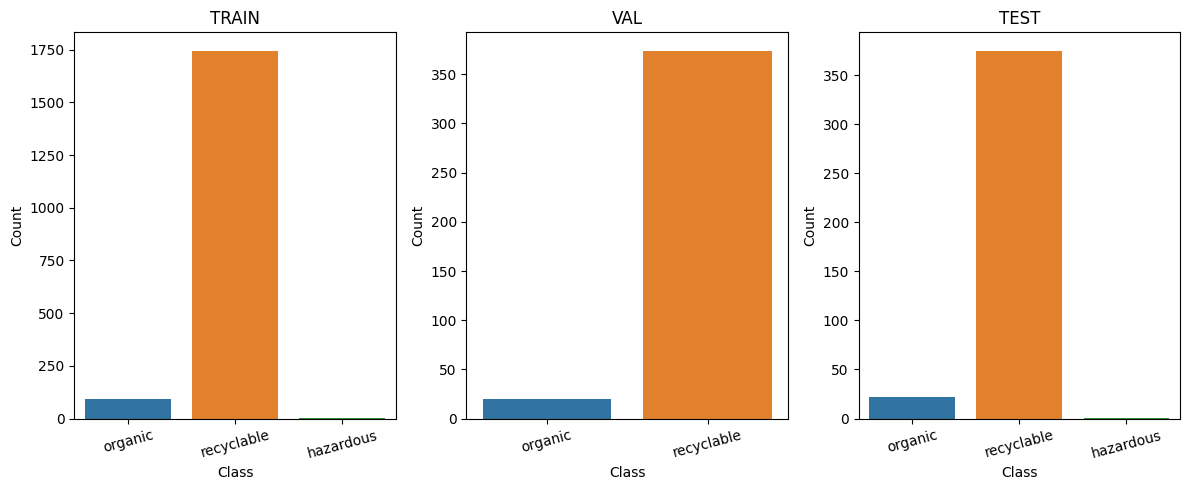

In [9]:
plt.figure(figsize=(12,5))
for i, split_name in enumerate(["train", "val", "test"]):
    plt.subplot(1, 3, i + 1)
    cls_counts = counts[split_name]
    # filter out empty classes
    cls_counts = {k:v for k,v in cls_counts.items() if v>0}
    if cls_counts:
        df = pd.DataFrame(list(cls_counts.items()), columns=["Class","Count"])
        sns.barplot(x="Class", y="Count", data=df)
        plt.title(split_name.upper())
        plt.ylabel("Count")
        plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Pie chart for merged dataset

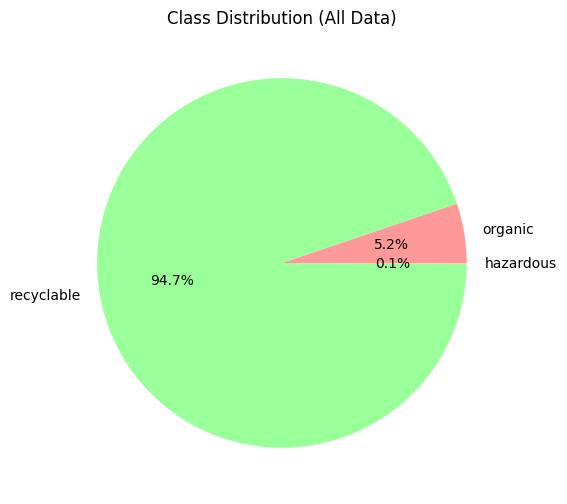

In [10]:
total_counts = {cls: sum(counts[split][cls] for split in counts if cls in counts[split]) for cls in ["organic", "recyclable", "hazardous"]}
# filter out zero-count classes
total_counts = {k:v for k,v in total_counts.items() if v>0}

plt.figure(figsize=(6,6))
plt.pie(list(total_counts.values()), labels=list(total_counts.keys()), autopct="%1.1f%%", colors=["#FF9999","#99FF99","#FFCC99"])
plt.title("Class Distribution (All Data)")
plt.show()

# Show Sample Images

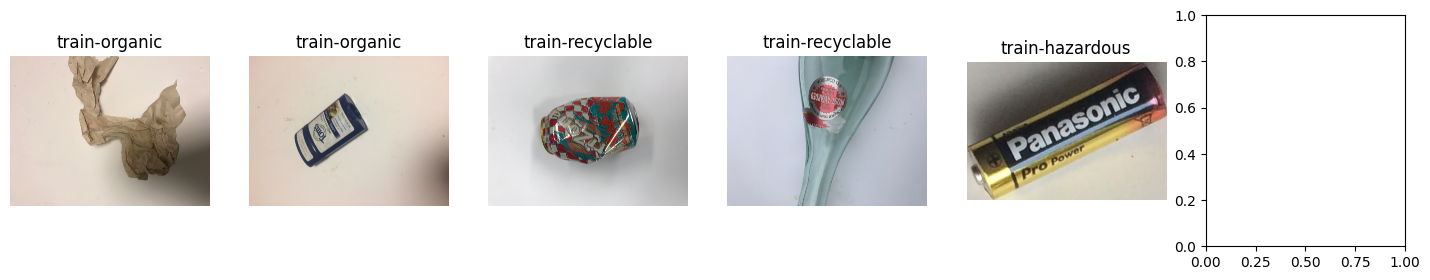

In [11]:
def show_samples(split="train", n_per_class=2):
    classes = [cls for cls in ["organic", "recyclable", "hazardous"] if (FINAL_DIR / split / cls).exists()]
    n_cols = n_per_class * len(classes)
    fig, axes = plt.subplots(1, n_cols, figsize=(3*n_cols, 3))
    axes = axes.flatten() if n_cols>1 else [axes]

    idx = 0
    for cls in classes:
        path = list((FINAL_DIR / split / cls).glob("*.jpg"))
        if not path:
            continue
        for j in range(min(n_per_class, len(path))):
            img_path = random.choice(path)
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].axis("off")
            axes[idx].set_title(f"{split}-{cls}")
            idx += 1
    plt.show()

show_samples("train")

# Merge New Datasets For Organic and Hazardous classes

In [12]:
import uuid
from glob import glob
random.seed(42)

# Step 2: Paths
FINAL_DIR = Path("/kaggle/working/datasets/final")
NEW_DATA_ROOT = Path("/kaggle/input/organic-and-hazardous-datasets")
NEW_DATA_MAP = {
    "organic": NEW_DATA_ROOT / "organic" / "organic",
    "hazardous": NEW_DATA_ROOT / "hazardous" / "hazardous"
}

TARGET_CLASSES = ["organic","recyclable","hazardous"]
EXTS = {".jpg",".jpeg",".png",".JPG",".JPEG",".PNG",".bmp",".webp"}

# Merge new dataset into Final Dataset
splits = ["train","val","test"]
merge_log = {}

for cls, src_folder in NEW_DATA_MAP.items():
    if not src_folder.exists():
        print(f"Source not found: {src_folder}")
        continue

    files = [f for ext in EXTS for f in src_folder.rglob(f"*{ext}")]
    random.shuffle(files)
    total_files = len(files)

    # Train/Val/Test split proportionally
    n_train = int(total_files * 0.7)
    n_val   = int(total_files * 0.15)
    n_test  = total_files - n_train - n_val

    split_counts = {"train": n_train, "val": n_val, "test": n_test}
    start_idx = 0

    for split in splits:
        end_idx = start_idx + split_counts[split]
        split_files = files[start_idx:end_idx]
        start_idx = end_idx

        out_dir = FINAL_DIR / split / cls
        out_dir.mkdir(parents=True, exist_ok=True)

        copied = 0
        for f in split_files:
            try:
                new_name = f"{uuid.uuid4().hex}{f.suffix.lower()}"
                shutil.copy(f, out_dir / new_name)
                copied += 1
            except:
                continue
        merge_log[f"{split}-{cls}"] = copied

# Merge summary
print("New dataset merge summary:")
for k,v in merge_log.items():
    print(f"{k}: {v} files added")

# Count final images per split/class
counts = {split:{} for split in splits}
for split in splits:
    for cls in TARGET_CLASSES:
        path = FINAL_DIR / split / cls
        counts[split][cls] = len(list(path.glob("*.*"))) if path.exists() else 0

print("\nFinal counts per split/class:")
for split in splits:
    print(f"{split.upper()}: {counts[split]}")

New dataset merge summary:
train-organic: 1631 files added
val-organic: 349 files added
test-organic: 350 files added
train-hazardous: 1239 files added
val-hazardous: 265 files added
test-hazardous: 267 files added

Final counts per split/class:
TRAIN: {'organic': 1726, 'recyclable': 1745, 'hazardous': 1240}
VAL: {'organic': 369, 'recyclable': 374, 'hazardous': 265}
TEST: {'organic': 372, 'recyclable': 375, 'hazardous': 268}


# Bar plot for each split

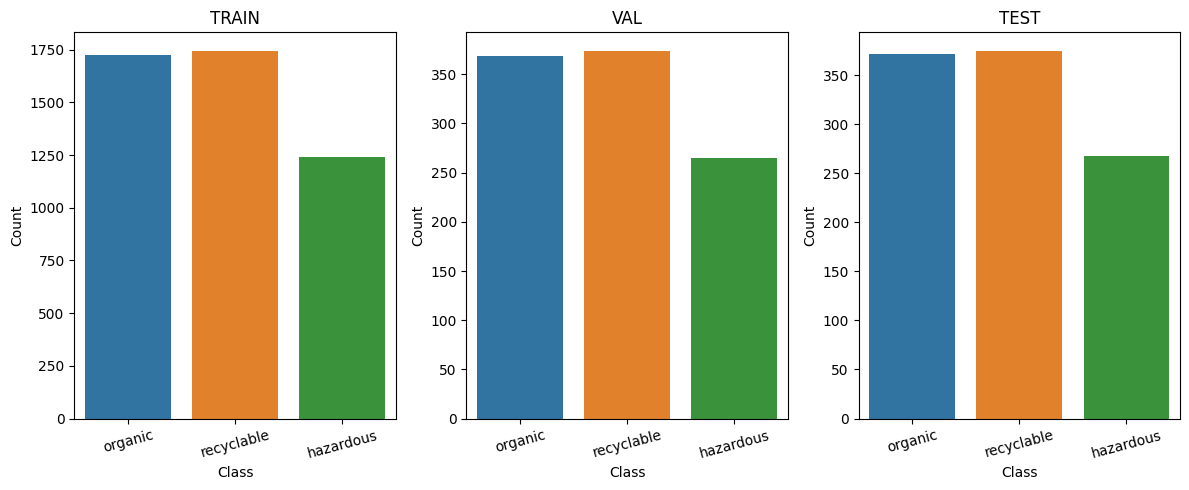

In [13]:
plt.figure(figsize=(12,5))
for i, split in enumerate(splits):
    plt.subplot(1, 3, i+1)
    cls_counts = {k:v for k,v in counts[split].items() if v>0}
    if cls_counts:
        df = pd.DataFrame(list(cls_counts.items()), columns=["Class","Count"])
        sns.barplot(x="Class", y="Count", data=df)
        plt.title(split.upper())
        plt.ylabel("Count")
        plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Pie chart for overall class distribution

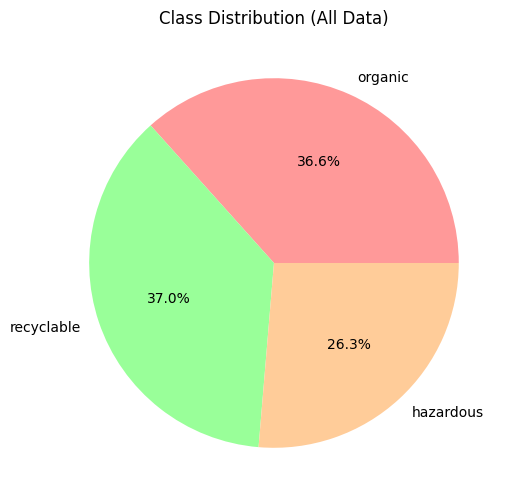

In [14]:
total_counts = {cls: sum(counts[split][cls] for split in splits if cls in counts[split]) for cls in TARGET_CLASSES}
total_counts = {k:v for k,v in total_counts.items() if v>0}

plt.figure(figsize=(6,6))
plt.pie(list(total_counts.values()), labels=list(total_counts.keys()), autopct="%1.1f%%",
        colors=["#FF9999","#99FF99","#FFCC99"])
plt.title("Class Distribution (All Data)")
plt.show()

# Show sample images per split/class

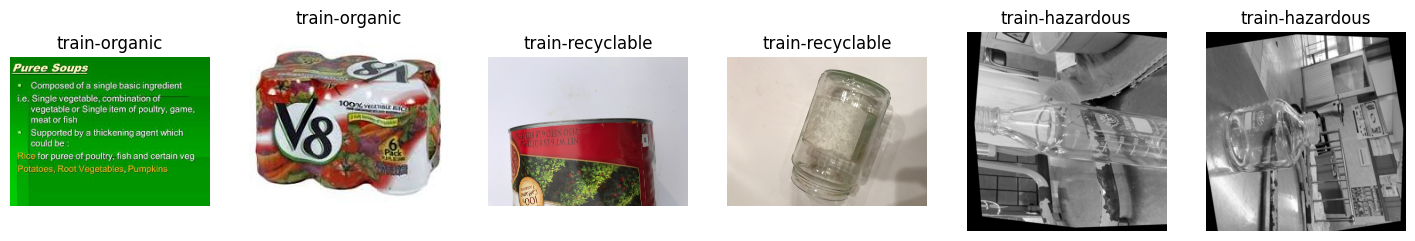

In [15]:
def show_samples(split="train", n_per_class=2):
    classes = [cls for cls in TARGET_CLASSES if (FINAL_DIR / split / cls).exists()]
    n_cols = n_per_class * len(classes)
    fig, axes = plt.subplots(1, n_cols, figsize=(3*n_cols, 3))
    axes = axes.flatten() if n_cols>1 else [axes]

    idx = 0
    for cls in classes:
        path = list((FINAL_DIR / split / cls).glob("*.*"))
        if not path:
            continue
        for j in range(min(n_per_class, len(path))):
            img_path = path[j]
            img = Image.open(img_path)
            axes[idx].imshow(img)
            axes[idx].axis("off")
            axes[idx].set_title(f"{split}-{cls}")
            idx += 1
    plt.show()

show_samples("train")

# EDA on Final Datasets

Image counts collected


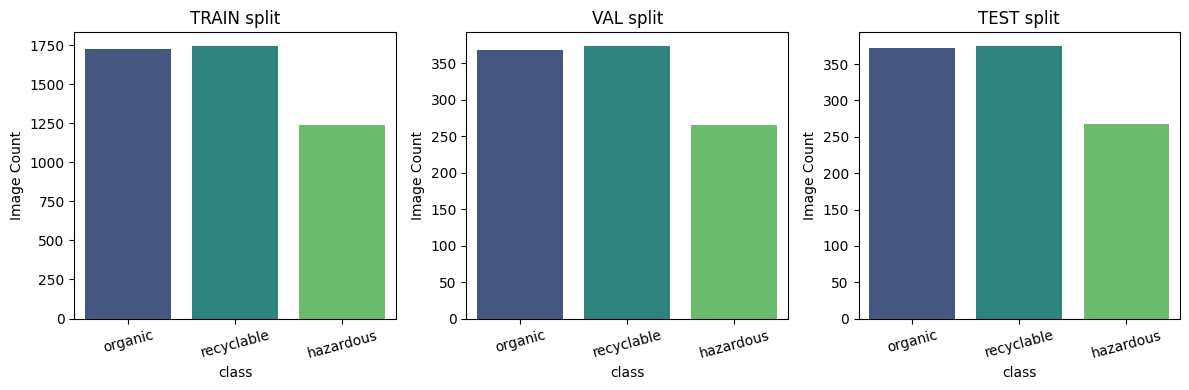


Class Distribution Ratios:

TRAIN (4711 images)
  organic   : 1726 (36.64%)
  recyclable: 1745 (37.04%)
  hazardous : 1240 (26.32%)

VAL (1008 images)
  organic   : 369 (36.61%)
  recyclable: 374 (37.10%)
  hazardous : 265 (26.29%)

TEST (1015 images)
  organic   : 372 (36.65%)
  recyclable: 375 (36.95%)
  hazardous : 268 (26.40%)


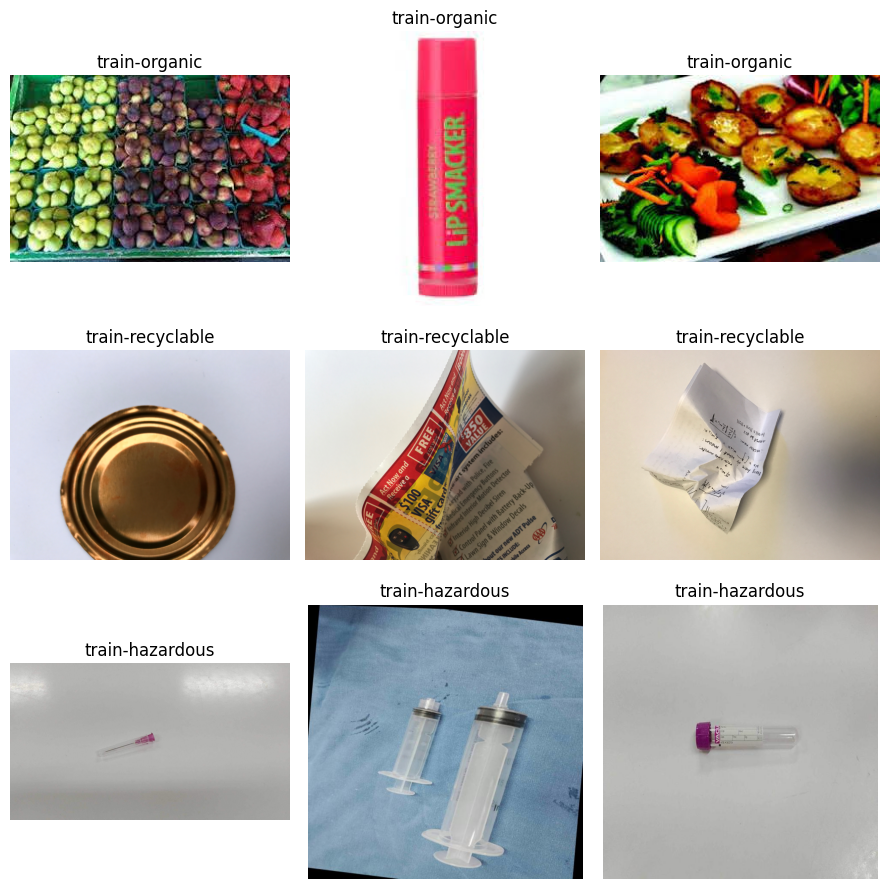

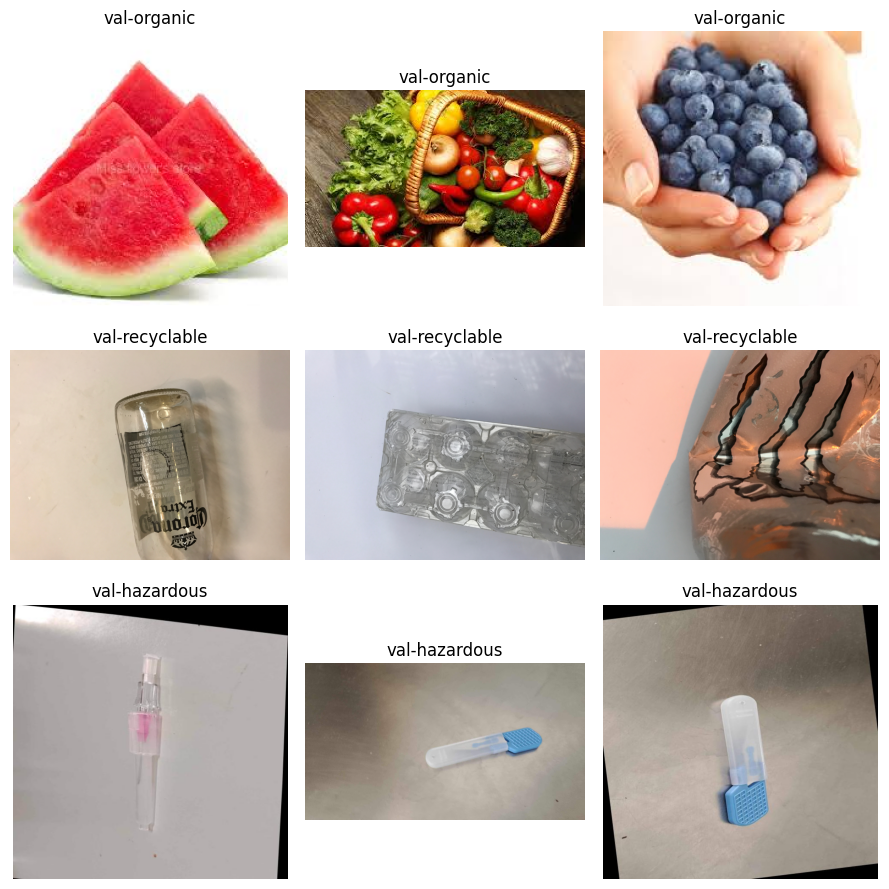

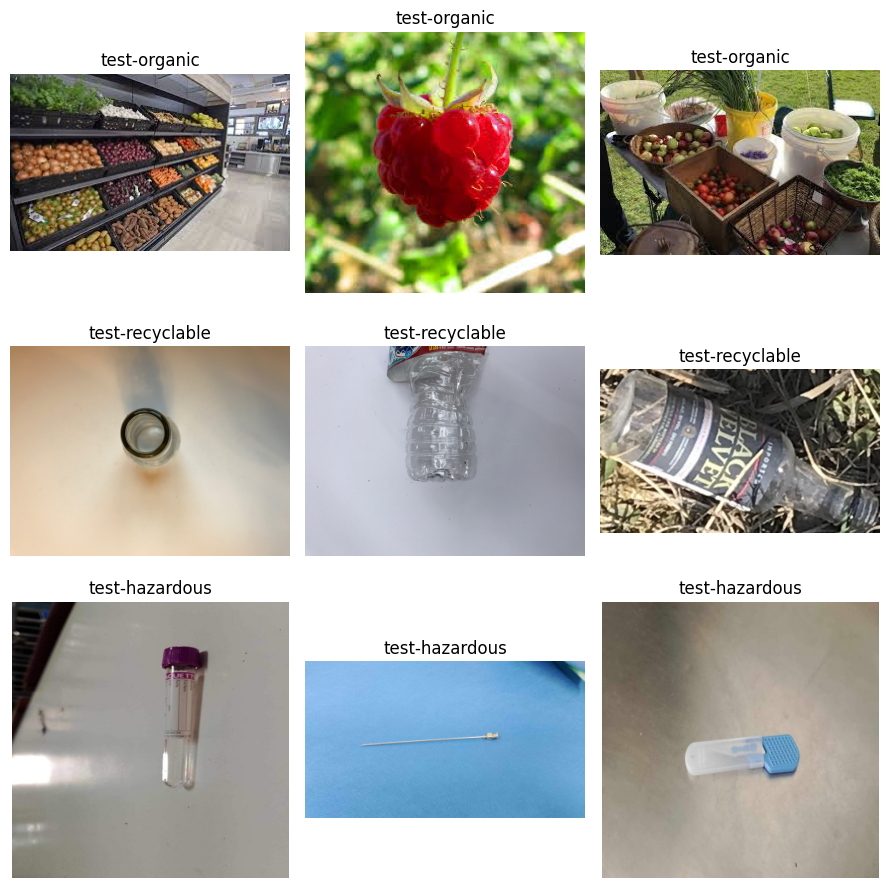

In [16]:
FINAL_DIR = Path("/kaggle/working/datasets/final")

splits = ["train", "val", "test"]
classes = ["organic", "recyclable", "hazardous"]

# Count Images per Class
counts = {}
for split in splits:
    counts[split] = {}
    for cls in classes:
        path = FINAL_DIR/split/cls
        n = len(os.listdir(path)) if path.exists() else 0
        counts[split][cls] = n

print("Image counts collected")

# Plot Class Distribution (DataFrame style)
plt.figure(figsize=(12,4))
for i,split in enumerate(splits):
    data = pd.DataFrame({
        "class": list(counts[split].keys()),
        "count": list(counts[split].values())
    })
    plt.subplot(1,3,i+1)
    sns.barplot(data=data, x="class", y="count", palette="viridis")
    plt.title(f"{split.upper()} split")
    plt.ylabel("Image Count")
    plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Imbalance Check (Ratios)
print("\nClass Distribution Ratios:")
for split in splits:
    total = sum(counts[split].values())
    print(f"\n{split.upper()} ({total} images)")
    for cls in classes:
        pct = counts[split][cls]/total*100 if total>0 else 0
        print(f"  {cls:<10}: {counts[split][cls]} ({pct:.2f}%)")

# Show Random Sample Images
def show_samples(split="train", n_per_class=3):
    fig, axes = plt.subplots(len(classes), n_per_class, figsize=(n_per_class*3, len(classes)*3))
    for i,cls in enumerate(classes):
        path = FINAL_DIR/split/cls
        img_list = list(path.glob("*")) if path.exists() else []
        for j in range(n_per_class):
            if img_list:
                img_path = random.choice(img_list)
                img = Image.open(img_path)
                axes[i][j].imshow(img)
                axes[i][j].axis("off")
                axes[i][j].set_title(f"{split}-{cls}")
            else:
                axes[i][j].axis("off")
                axes[i][j].set_title(f"{split}-{cls} (empty)")
    plt.tight_layout()
    plt.show()

# Show samples safely
show_samples("train", n_per_class=3)
show_samples("val", n_per_class=3)
show_samples("test", n_per_class=3)

# Imports, Config and Detect accelerator

In [20]:
# =====================
# 0. Imports & Config
# =====================
import os, random, datetime, json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
import joblib

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Detect accelerator
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    STRATEGY = tf.distribute.TPUStrategy(tpu)
    print("Using TPU")
except Exception:
    gpus = tf.config.list_physical_devices('GPU')
    if len(gpus) > 1:
        STRATEGY = tf.distribute.MirroredStrategy()
        print("Using Multi-GPU")
    else:
        STRATEGY = tf.distribute.get_strategy()
        print("Using Single GPU/CPU")

# Mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
MIXED = True
print("Mixed precision enabled")

Using Single GPU/CPU
Mixed precision enabled


# Paths, Hyperparameters and Utility functions 

In [21]:
# =====================
# 1. Paths & Hyperparameters
# =====================
DATA_DIR = '/kaggle/working/datasets/final'
OUTPUT_DIR = '/kaggle/working/ensemble_pipeline_updated'
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

NUM_EPOCH_FE = 6
NUM_EPOCH_FT = 12
LR_FE = 1e-3
LR_FT = 1e-4

TEMPERATURE = 3.0
ALPHA = 0.3

# =====================
# 2. Utility functions
# =====================
def plot_history(hist, title='History', savepath=None):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history.get('loss', []), label='loss')
    plt.plot(hist.history.get('val_loss', []), label='val_loss')
    plt.legend(); plt.title(title + ' - Loss'); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(hist.history.get('accuracy', []), label='acc')
    plt.plot(hist.history.get('val_accuracy', []), label='val_acc')
    plt.legend(); plt.title(title + ' - Acc'); plt.grid(True)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()

def evaluate_and_report(model, ds, class_names, name='model', saveprefix=None):
    probs = model.predict(ds, verbose=0)
    y_true = np.concatenate([y for _, y in ds], axis=0)
    y_true_idx = np.argmax(y_true, axis=1)
    y_pred_idx = np.argmax(probs, axis=1)

    acc = accuracy_score(y_true_idx, y_pred_idx)
    print(f"== {name} == Acc: {acc:.4f}")
    report = classification_report(y_true_idx, y_pred_idx, target_names=class_names, output_dict=True)
    print(classification_report(y_true_idx, y_pred_idx, target_names=class_names))

    cm = confusion_matrix(y_true_idx, y_pred_idx)
    plt.figure(figsize=(6,5)); plt.imshow(cm, interpolation='nearest'); plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha='right'); plt.yticks(ticks, class_names)
    plt.title(f'Confusion Matrix - {name}'); plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout()
    if saveprefix:
        plt.savefig(saveprefix + f'_{name}_confusion.png')
    plt.show()

    return probs, y_true_idx, report


# Data loading & augmentation

In [23]:
# =====================
# 3. Data loading & augmentation
# =====================
def make_ds(dir_path, augment=False):
    raw_ds = tf.keras.utils.image_dataset_from_directory(
        dir_path,
        image_size=(IMG_SIZE, IMG_SIZE),
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=SEED
    )

    # save class names only once (from train dataset)
    global class_names
    if 'class_names' not in globals():
        class_names = raw_ds.class_names

    # Augmentation layers
    aug_layer = keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.08),
        layers.RandomZoom(0.08),
        layers.RandomBrightness(0.1),
        layers.RandomContrast(0.1)
    ])

    rescale = layers.Rescaling(1./127.5, offset=-1)

    def _map(imgs, labels):
        if augment:
            imgs = aug_layer(imgs)
        imgs = rescale(imgs)
        return imgs, labels

    ds = raw_ds.map(_map, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
    return ds


# Create datasets
train_ds = make_ds(os.path.join(DATA_DIR, 'train'), augment=True)
val_ds   = make_ds(os.path.join(DATA_DIR, 'val'), augment=False)
test_ds  = make_ds(os.path.join(DATA_DIR, 'test'), augment=False)

# ✅ class_names works now
NUM_CLASSES = len(class_names)
print('Classes:', class_names)


Found 4711 files belonging to 3 classes.
Found 1008 files belonging to 3 classes.
Found 1015 files belonging to 3 classes.
Classes: ['hazardous', 'organic', 'recyclable']


# Base model factory

In [24]:
# =====================
# 4. Base model factory
# =====================
def build_base_model(name):
    with STRATEGY.scope():
        inp = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
        if name=='MobileNetV2':
            base = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet', input_tensor=inp)
        elif name=='NASNetMobile':
            base = tf.keras.applications.NASNetMobile(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet', input_tensor=inp)
        elif name=='InceptionV3':
            base = tf.keras.applications.InceptionV3(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet', input_tensor=inp)
        else:
            raise ValueError('Unknown base model')
        base.trainable=False
        x = base.output
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)
        out = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)
        model = keras.Model(inputs=inp, outputs=out, name=name)
        model.compile(optimizer=keras.optimizers.Adam(LR_FE), loss='categorical_crossentropy', metrics=['accuracy'])
        return model, base

mbv2_model, mbv2_base = build_base_model('MobileNetV2')
nas_model, nas_base = build_base_model('NASNetMobile')
inc_model, inc_base = build_base_model('InceptionV3')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Training helpers (FE + FT)

In [25]:
# =====================
# 5. Training helpers (FE + FT)
# =====================
def train_model(model, train_ds, val_ds, epochs, base_model=None, lr=LR_FE, name='model'):
    ckpt = os.path.join(OUTPUT_DIR, f'{name}_best.keras')
    callbacks = [
        keras.callbacks.ModelCheckpoint(ckpt, monitor='val_accuracy', save_best_only=True, verbose=1),
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    ]
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, verbose=1)
    return hist, ckpt

def fine_tune_model(model, base_model, train_ds, val_ds, epochs, lr=LR_FT, unfreeze_fraction=0.2, name='model'):
    total_layers = len(base_model.layers)
    start = int(total_layers*(1-unfreeze_fraction))
    for i, layer in enumerate(base_model.layers):
        layer.trainable = True if i>=start and not isinstance(layer, layers.BatchNormalization) else False
    with STRATEGY.scope():
        model.compile(optimizer=keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return train_model(model, train_ds, val_ds, epochs, base_model, lr, name)

# Train all base models

In [ ]:
# =====================
# 6. Train all base models
# =====================
hist_mbv2_fe, _ = train_model(mbv2_model, train_ds, val_ds, NUM_EPOCH_FE, name='MobileNetV2_FE')
hist_mbv2_ft, _ = fine_tune_model(mbv2_model, mbv2_base, train_ds, val_ds, NUM_EPOCH_FT, name='MobileNetV2_FT')

hist_nas_fe, _ = train_model(nas_model, train_ds, val_ds, NUM_EPOCH_FE, name='NASNet_FE')
hist_nas_ft, _ = fine_tune_model(nas_model, nas_base, train_ds, val_ds, NUM_EPOCH_FT, name='NASNet_FT')

hist_inc_fe, _ = train_model(inc_model, train_ds, val_ds, NUM_EPOCH_FE, name='InceptionV3_FE')
hist_inc_ft, _ = fine_tune_model(inc_model, inc_base, train_ds, val_ds, NUM_EPOCH_FT, name='InceptionV3_FT')


Epoch 1/6
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8699 - loss: 0.4410
Epoch 1: val_accuracy improved from -inf to 0.96627, saving model to /kaggle/working/ensemble_pipeline_updated/MobileNetV2_FE_best.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 664s 2s/step - accuracy: 0.8701 - loss: 0.4406 - val_accuracy: 0.9663 - val_loss: 0.1156 - learning_rate: 0.0010
Epoch 2/6
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9608 - loss: 0.1159
Epoch 2: val_accuracy improved from 0.96627 to 0.97619, saving model to /kaggle/working/ensemble_pipeline_updated/MobileNetV2_FE_best.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 576s 2s/step - accuracy: 0.9608 - loss: 0.1159 - val_accuracy: 0.9762 - val_loss: 0.0830 - learning_rate: 0.0010
Epoch 3/6
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9760 - loss: 0.0745
Epoch 3: val_accuracy did not improve from 0.97619
295/295 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.9760 - loss: 0.0745 - val_accuracy: 0.9673 - val_loss: 0.1058 - learning_rate: 0